# 손실곡선
사이킷 런에서 제공하는 머신러닝 알고리즘들은 매개변수를 조정하고 훈련하는 과정을 반복했다.  
반면 딥러닝에서는 모델의 구조를 직접 만드는 느낌이 강하다.  
층을 추가하고 층에 있는 뉴런의 개수와 활성화 함수를 결정하는 작업을 거쳐야 했다.  
때문에 프로그래머에게는 딥러닝이 좀 더 친숙하게 느껴질 수 있다.

In [1]:
# 데이터 적재, 훈련세트와 검증세트로 분할
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

4422102/4422102 [==============================] - 0s 0us/step


모델 만들기  
단, 그 전에 모델을 만드는 함수를 정의

In [2]:
def model_fn(a_layer = None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation = 'relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation= 'softmax'))
  return model

함수로 모델을 만들었다.  
이것을 출력해보자.  

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 5, verbose = 0)

verbose 매개변수는 훈련과정 출력을 조절한다, 기본 값은 1이고  
에포크 진행막대와 손실 지표가 출력된다.  
2로 할 경우, 진행 막대를 빼고 출력한다.  
0으로 할 경우, 훈련 과정을 나타내지 않는다.  


In [5]:
# history 객체의 값을 확인, 내용물은 손실과 정확도로 구성된 딕셔너리
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


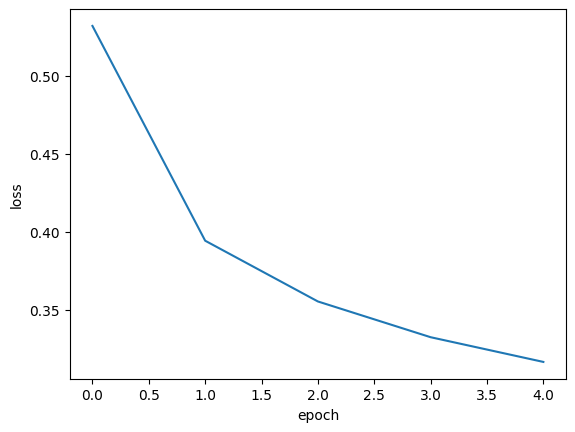

In [6]:
# 손실 출력
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

5개의 에포크가 0에서부터 4까지  손실된 값이 표현된다.

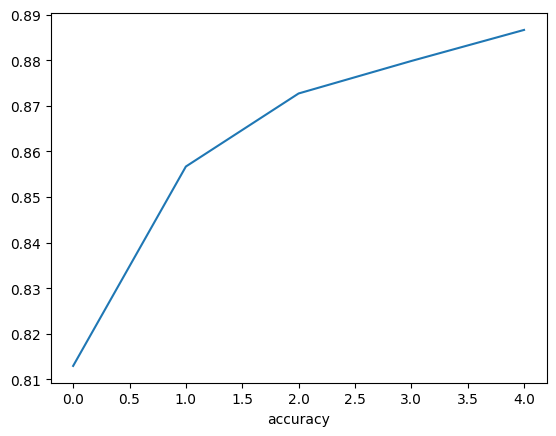

In [7]:
# 정확도 출력
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.xlabel('accuracy')
plt.show()

에포크가 진행될 수록 정확도가 올라간다.  
에포크마다 손실이 감소하고 정확도가 올라가는 것을 볼 수 있다.

---
테스트  
에포크가 늘어날수록 손실이 감소하고 정확도가 향상된다.  
그렇다면 무작정 늘려볼까?

<function matplotlib.pyplot.show(close=None, block=None)>

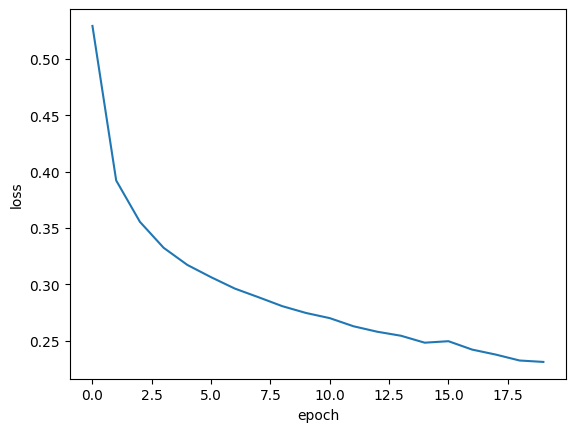

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

확실히 손실이 아주 잘 감소한다.  
그런데 뭔가 잊고 있는게 있지 않은가?

# 검증 손실
확률적 경사하강법을 사용할 때 과대/과소적합과 에포크 사이의 관계를 알아봤다.  
에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라  
검증에 대한 점수도 필요하다.  
즉, 훈련세트와 검증세트의 그래프를 같이 그려보아야 한다.  

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose =0, validation_data = (val_scaled, val_target))

In [10]:
# 변환된 history.history 딕셔너리에 어떤 값이 들어있는지 키를 확인해보자
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


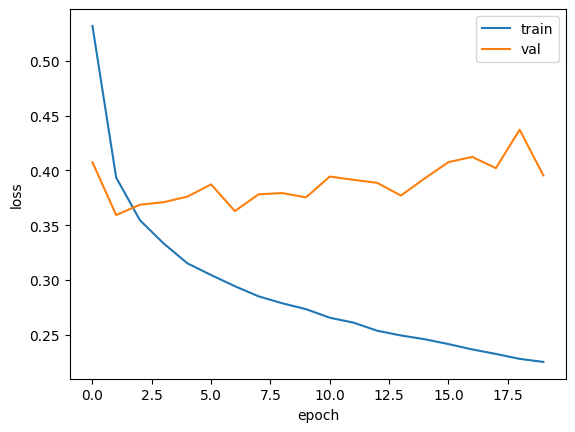

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


초기에 검증손실이 감소하다가 다시 상승하기 시작한다.  
훈련 손실은 꾸준히 감소하기에 전형적인 과대적합 모델이 만들어진다.  
검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증세트에 대한 정확도도 증가할 것이다.  

---
과대적합을 막기 위해, 규제 방식 대신 신경망에 특화된 규제 방법을 해야한다.  
다만 지금은 옵티마이저 하이퍼파라미터를 조정하여 과대적합을  
완화시킬 수 있는지 알아보자  


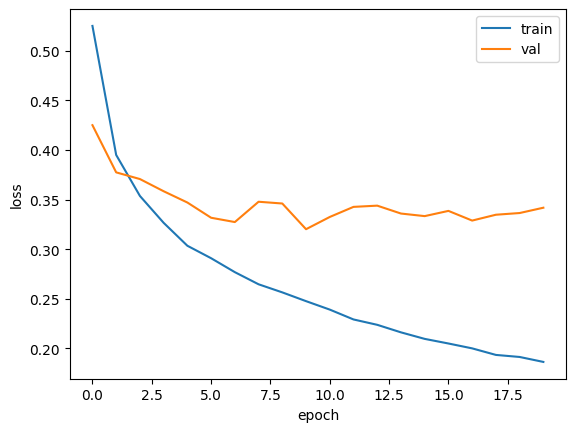

In [12]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


과대적합이 훨씬 줄었다.  
검증 손실 그래프에 여전히 요동이 남아있지만 열 번째 에포크까지 지점까지는 얼추 감소하는 듯 하다.  
더 나은 손실 곡선을 얻고자 한다면 학습률을 조정해서 다시 시도해 볼 수 있다.  
그러나 지금은 여기까지만 하자

# 드롭아웃
이 방식은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(뉴런 출력을 0으로 만들어 과대 적합을 막는다.  

케라스에서는 드롭아웃을 keras.layers패키지 아래 Dropout 클래스로 제공한다.

In [14]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃 층은 훈련 파라미터가 없다.  
또한 입출력 크기가 같다.  
일부 뉴련의 출력을 0으로 만들지만 전체 출력 배열 크기를 바꾸지는 않는다.  
훈련이 끝난 뒤에는 평가나 예측을 수행하는 드롭아웃을 적용하면 안된다.  
  
하지만 텐서플로와 케라스에서는 모델을 평가&예측할 때는 드롭아웃을 자동으로 뺀다.  


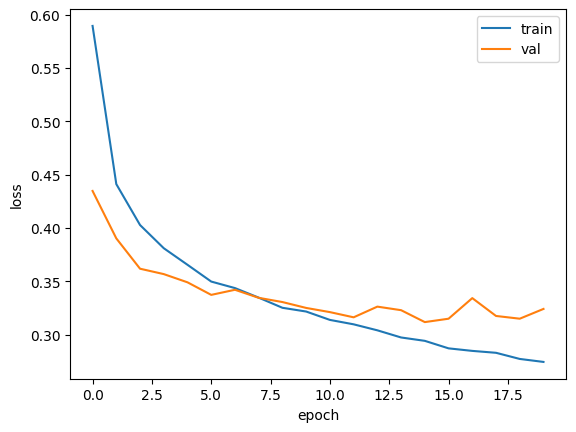

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()



과대적합이 크게 줄었다.  
열 번째 에포크 정도에서 검증 손실감소에 멈추는 경향을 보인다.  
과대적합되지 않은 모델을 얻기 위해 에포크를 10번 정도로 하고 다시 훈련하자  


In [17]:
# 에포크를 10으로 하고 모델을 훈련
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 10, verbose=0, validation_data=(val_scaled, val_target))

# 모델 저장과 복원
케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드를 제공한다.  
기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우, HDF5 포맷으로 저장한다.  

In [22]:
model.save_weights('model-weights.h5')

모델 구조와 모델 파라미터를 함께 저장할때는 save()메서드를 사용한다.

In [19]:
model.save('model-whole.h5')

이제 이 두 파일이 잘 만들어졌는지 확인

In [20]:
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Apr 15 02:31 medel-weights.h5
-rw-r--r-- 1 root root 981176 Apr 15 02:39 model-whole.h5


두 가지 테스트를 해보자  
1. 훈련하지 않은 새 모델에 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용.  
2. 아예 model-weights.h5 파일에서 새로운 모델을 만들어 바로 사용  
  
우선 첫번째 실험부터 시작

In [23]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

save_weights()와 쌍을 이루는 것이 load_weights() 메서드다.  
load_weights()메서드를 쓰려면 save_weights()메서드로 저장했던 모델과 정확히 같은 구조를 가져아 한다.  
여기서는 model_fn 함수를 사용해 동일한 모델을 만들어 사용했다.  

패션MNIST 데이터 셋에서 덜어낸 검증 세트의 샘플은 12000개다.  
때문에 predict() 메서드는 (12000, 10) 크기의 배열을 반환한다.  
10개의 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해 보자  

In [26]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis = -1)    # argmax는 가장 큰 값을 고르기 위한 함수
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.12725


왜 보수 값이 나올까??

In [27]:
# 모델 전체 파일에서 읽은 다음 검증 세트의 정확도를 출력한다.
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.3341 - accuracy: 0.8791


[0.33406415581703186, 0.8790833353996277]

값이 약간 다르게 나왔다.

# 콜백
콜백은 훈련과정 중간에 어떤 작업을 수행하게 해주는 객체로 keras.callbacks 패키지에 있는 클래스다.  
fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다.  
ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다.  
save_best_only = True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.  


In [30]:
# 저장될 파일 이름은 best-model.h5
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only = True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data = (val_scaled, val_target), callbacks=[checkpoint_cb])

model_fn() 함수로 모델을 만들고 compile() 메서드를 호출하는건 동일하다.  
ModelCheckpoint 클래스의 객체 checkpoint_cb를 만들고 fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다.  
모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장된다.  
이 모델을 load_model() 함수로 다시 읽어서 예측을 수행해보자

In [31]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3186 - accuracy: 0.8846


[0.3185843825340271, 0.8845833539962769]

검증점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다.  
이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다.  
이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 조기종료라고 하며  
딥러닝 분야에서 널리 사용된다.  

---
케라스에서는 조기종료를 위한 EarlyStopping 콜백을 제공한다.  
이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다.  
예를 들어, patience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다.  

--- 
EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다.  
  
이 두개를 함께 사용해보자

In [32]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights=True )
history =model.fit(train_scaled, train_target, epochs= 20, verbose = 0, validation_data=(val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

EarlyStopping 콜백을 추가한 것 외에는 이전과 동일하다.

In [33]:
print(early_stopping_cb.stopped_epoch)

10


10은 11번째 에포크에서 훈련이 중지되었다는 것을 의미한다.  
훈련손실과 검증손실을 출력해서 확인해보자

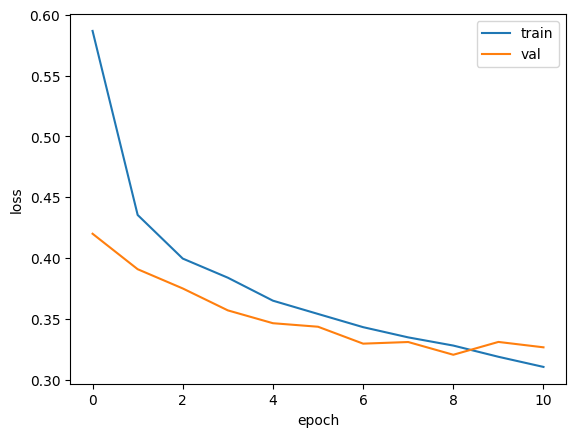

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()



11번째 에포크에서 훈련이 중지되었다.  
ModelCheckpoint 콜백과 함께 사용하면 최상의 모델을 자동으로 저장하므로 편리하다.  
마지막으로 조기종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해보자

In [35]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3204 - accuracy: 0.8832


[0.32039836049079895, 0.8832499980926514]

# 정리
인공 신경망 모델 훈련을 위한 다양한 도구를 배웠다.  
### 드롭아웃
은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법
### 콜백
케라스 모델을 훈련하는 도중, 어떤 작업을 수행할 수 있도록 도와주는 도구로  
최상의 모델을 자동으로 저장해주거나 검증점수가 더 이상 향상되지 않으면 조기종료 한다.  
### 조기종료
검증점수가 더 이상 감소하지 않고 상승하여 과대적합이 일어나면 훈련을 중도에 멈추는 기법  
이렇게 하면 계산 비용과 시간을 절약할 수 있다.